In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# 4-2 의사 결정 나무(Decision Tree)

## 0. 데이터셋 소개

### Titanic

[Titanic](https://www.kaggle.com/competitions/titanic/data) 탑승객의 생존 유무를 담은 데이터셋 입니다.

|Data|Dictionary|Key|
|:----|:----------|:---|
|PassengerId|Passenger Id|Index|
|Survived|Survival|0 = No, 1 = Yes|
|Pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd|
|Name|Name|
|Sex|Sex|
|Age|Age in years|
|Sibsp|# of siblings / spouses aboard the Titanic|
|Parch|# of parents / children aboard the Titanic|	
|Ticket|Ticket number|
|Fare|Passenger fare|	
|Cabin|Cabin number|
|Embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton|


다양한 형식의 데이터를 가지고 있으며, 여러 가지 아이디어를 생각하고 시도할 만한 요소가 많게끔 기획된 데이터셋입니다.

In [2]:
df_titanic = pd.read_csv('data/titanic.csv', index_col='PassengerId')

In [3]:
df_titanic.isna().sum().to_frame().T

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,177,0,0,0,0,687,2


전처리: Pclass와 Embarked를 가변수화 합니다.

In [4]:
# Embarked의 결측치는 최빈값으로,
# Age의 결측치는 평균으로 대체합니다.
# 범주형 변수는 가변수화하여 수치형 변수화 동일하게 취급합니다.
# Sex은 female, male 두 개의 범주이므로 이진형으로 바꿉니다.
df_titanic = pd.get_dummies(
    df_titanic.assign(
        Embarked = lambda x: x['Embarked'].fillna(x['Embarked'].mode().iloc[0]),
        Age = lambda x: x['Age'].fillna(x['Age'].mean()),
    ), columns=['Pclass', 'Embarked']
).assign(
    Sex = lambda x: x['Sex'] == 'female'
)
# 머신러닝에 사용할 변수들을 정리합니다.
X_num = ['Age', 'SibSp', 'Parch', 'Fare']
X_dum = [i for i in df_titanic.columns if i.startswith('Pclass') or i.startswith('Sex') or i.startswith('Embarked')]
X_all = X_num + X_dum
X_all

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

## 1. 종류 및 특징


|모델명|특징|
|:---|:---|
|ID3<br/>(Iterative Dichotomiser 3)|1. 분류에 사용됩니다.<br/> 2. 범주형 입력 데이터만 지원합니다.|
|C4.5|1. 연속형 입력 데이도 지원합니다.<br/>2. 의사 결정 나무의 구조를 만든 후에 가지치기를 지원합니다.|
|CART<br/>(Classification and Regression Trees)|1. 분류와 회귀 에 사용됩니다.|
|CHAID<br/>(Chi-squared Automatic Interaction Detector)|1. 범주형 입력 데이터만 지원합니다.<br/> 2. 두 개 이상의 가지를 지닙니다. <br/> 3. 분류에서는 Chi2 검정통계량을 회귀에서는 ANOVA 검정통계량을 사용합니다. |

## 2. 구성 요소

|요소명|설명|
|-----|---|
|내부 노드(Internal Node)|분기 조건과 결정 경로를 나타내는 가지(Branch)로 구성된 노드입니다. 이 중 최상위 노드를 루트 노드(Root Node)라고 합니다.|
|가지(Branch)|분기 조건에 해당하는 후속 노드와의 연결 관계를 나타내는 요소입니다.|
|리프 노드(Leaf Node)|가장 하위에 있는 노드로 더 이상 분기가 이루어지지 않고, 최종 예측 결과를 지니고 있는 노드 입니다.|

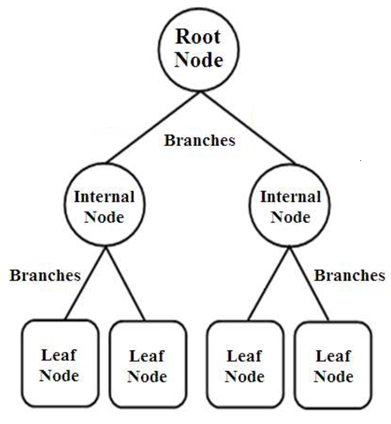

## 3.의사 결정 나무 학습

### 분기 조건의 선정

- 내부 노드(Internal Node)를 구성하는 분기 조건을 도출합니다.

#### 분기 조건의 표현

- 범주형일 경우 '변수명 = 범주', 연속형일 경우 '변수명 < 분리점' 


- scikit-learn의 Decision Tree를 기준으로 설명합니다.

>  scikit-learn의 의사 결정 나무는 범주형은 가변수화를 하여 연속형, 범주형 동일하게 취급하고 '변수명 <= 분리점'으로 조건을 나타냅니다.


#### 불순도

노드에 부여된 데이터의 대상 변수의 클래스가 혼재하는 정도를 나타냅니다.

##### 분류

1. 엔트로피(Entropy)

> $H(t) = -\sum_{i=1}^cp_ilog_2p_i$, t: 노드, $c$: 클래스의 수, $p_i$: i 클래스의 비율(출현 확률)

> $p_i$가 모두 동일할 경우 즉, 모든 확률이 $1/c$에 가까울 수록 엔트로피는 커집니다.

2. 지니 불순도(Gini impurity)

> $G(t) = \sum_{i=1}^cp_i(1 - p_i) = \sum_{i=1}^c\left(p_i - p_i^2\right)= 1 - \sum_{i=1}^cp_i^2$


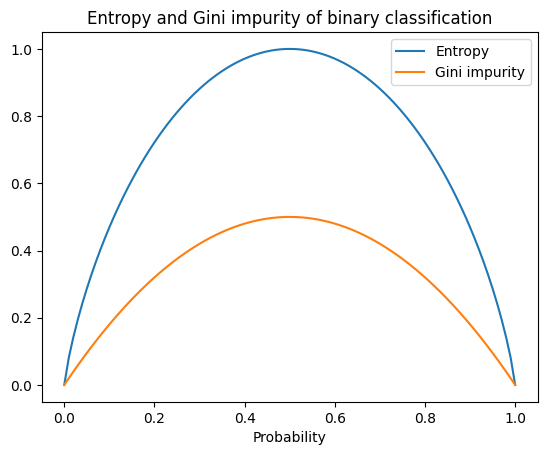

In [5]:
x = np.linspace(0, 1, 101)
x2 = x[1:-1]
e = np.hstack([[0], -(x2 * np.log2(x2) + (1 - x2) * np.log2(1 - x2)), [0]])
plt.plot(x, e, label='Entropy')
plt.plot(x, 1 - (x ** 2 + (1-x) ** 2), label='Gini impurity')
plt.gca().set_xlabel('Probability')
plt.gca().set_title('Entropy and Gini impurity of binary classification')
plt.legend()
plt.show()

##### 회귀

- 평균제곱오차(Mean Squared Error) 

> $MSE(t) = \frac{1}{n}\sum_{i=1}^c\sum_{j=1}^{n_i}\left(y_{ij} - \bar{y_i}\right)^2$, $c$: 클래스의 수, $n_i$: i 클래스의 데이터수

- 평균절대오차(Mean Absolute Error)

> $MAE(t) = \frac{1}{n}\sum_{i=1}^c\sum_{j=1}^{n_i}|y_{ij} - median(y)_i|$, $c$: 클래스의 수, $n_i$: i 클래스의 데이터수

#### 불순도 감소량

데이터의 분기에 의해 감소된 불순도

▷ 부모 노드의 불순도에서 자식노드들의 불순도(데이터수에 대한 불순도의 가중합)를 뺀 값입니다.

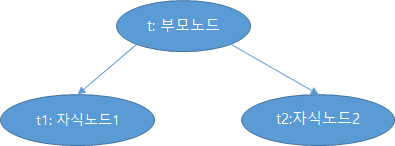

> $IG(t)$(t노드에 의해 감소된 불순도)$= imp(t) - \left(\frac{N(t_1)}{N(t)}imp(t1) + \frac{N(t_2)}{N(t)}imp(t2)\right)$ 

> $imp(t)$: t 노드의 불순도, $N(t)$: t 노드의 데이터수

특히, 엔트로피(Entropy)를 불순도로 사용했을 때 불순도 획득을 **정보 획득(Information Gain)**이라고 합니다.

#### Gini Index vs Entropy의 차이

Gini Impurity가 Entropy보다 스케일이 작기 때문에 자식노드의 데이터수의 가중치가 불순도 차감을 계산할 때 더 큰 영향을 주게 됩니다.

따라서 Gini Impurity로 불순도 차감을 계산할 때, 상대적으로 데이터의 수가 많은 노드들 위주로 분기가 이루어집니다.

**[Ex.1]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_titanic을 대상 변수 Survived에 대한 가변수 Pclass_1로 분기했을 때, Entropy로 불순도 차감을 계산합니다.
    
</div>

In [6]:
def entropy(x):
    """
    엔트로피를 구합니다.
    Parameters:
        x: array-like
    Returns:
        float: 엔트로피
    """
    return -np.sum(x * np.log2(np.where(x > 0, x, 1)))

def gini(x):
    """
    지니 불순도를 구합니다.
    Parameters:
        x: array-like
    Returns:
        float: 지니불순도
    """
    return 1 - np.sum(x ** 2)

In [7]:
# df_titanic에서 Survived의 불순도르 구합니다.
imp_func = entropy # entropy를 불순도로 사용합니다.
#imp_func = gini
imp_t = imp_func(df_titanic['Survived'].value_counts(normalize=True))
imp_t

0.9607079018756469

In [8]:
u = pd.Series(df_titanic['Pclass_1'].unique()).sort_values()
b = np.array([-np.inf] + ((u + u.shift(1)) / 2).dropna().tolist() + [np.inf])
n = len(df_titanic)
df_cnt = pd.crosstab(
    index = pd.cut(df_titanic['Pclass_1'], bins=b, right=True),
    columns = df_titanic['Survived']
).cumsum()
df_cnt

Survived,0,1
Pclass_1,,
"(-inf, 0.5]",469,206
"(0.5, inf]",549,342


**[참고]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

연속형 변수의 최적의 분기점을 찾기 위해서는 최악의 경우에는 데이터의 수만큼 선형 탐색을 해야 합니다.

백분위 기반으로 연속형 변수를 구간화하여 분기점 찾는 속도를 효율화하는 방법이 널리 쓰입니다.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
    
</div>

In [9]:
# 좌측 노드의 불순도와 가중치를 구합니다.
df_cnt.apply(
    lambda x: pd.Series([imp_func(x / x.sum()), x.sum() / n], index=['imp', 'weight']), axis=1
)

,imp,weight
Pclass_1,,
"(-inf, 0.5]",0.887537,0.757576
"(0.5, inf]",0.960708,1.000000


In [10]:
# 우측 노드의 불순도와 가중치를 구합니다.
(df_titanic['Survived'].value_counts().values - df_cnt).apply(
    lambda x: pd.Series([imp_func(x / x.sum()), x.sum() / n], index=['imp', 'weight']), axis=1
)

,imp,weight
Pclass_1,,
"(-inf, 0.5]",0.950956,0.242424
"(0.5, inf]",-0.000000,0.000000


In [11]:
# 좌측 노드와 우측 노드의 불순도를 가중합을 구합니다.
df_imp = df_cnt.apply(
    lambda x: imp_func(x / x.sum()) * x.sum() / n, axis=1
) + \
(df_titanic['Survived'].value_counts() - df_cnt).apply(
    lambda x: imp_func(x / x.sum()) * x.sum() / n, axis=1
)
df_imp

Pclass_1
(-inf, 0.5]    0.902911
(0.5, inf]     0.960708
dtype: float64

In [12]:
# 불순도 감소를 계산합니다. imp_t 분기 이전의 불순도
imp_t - df_imp

Pclass_1
(-inf, 0.5]    0.057796
(0.5, inf]     0.000000
dtype: float64

**[Ex.2]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_titanic 에서 gini 불순도를 사용하여 X_all 변수 리스트 각각의 Surivived 대한 불순도 차감을 구해봅니다.

그리고 sklearn.tree.DecisionTreeClassifier 를 X_all을 입력 변수로 대상 변수 Surivied를 최대 깊이(max_depth)를 2로 설정하여 학습하고,

나무를 출력하여 직접 계산한 결과와 비교해봅니다.
    
</div>

In [13]:
def ig(df, col, imp_func):
    """
    불순도 차감을 계산합니다.
    위 과정을 종합하여 하나의 함수로 정리했습니다.
    Parameters:
        df: pd.DataFrame
            데이터프레임
        col: str
            대상 컬럼
        imp_func: function
            불순도 계산 함수
    Returns:
        pd.Series
        ig: 불순도 차감, imp1: 좌측 영역의 불순도, imp2: 우측 영역의 불순도, n1: 좌측 영역의 데이터수, n2: 우측 영역의 데이터수
    """
    u = pd.Series(df[col].unique()).sort_values() # col 컬럼의 유일값을 구하고, 정렬합니다.
    b = np.array([-np.inf] + ((u + u.shift(1)) / 2).dropna().tolist() + [np.inf]) # 분류 경계를 구합니다.
    n = len(df)
    # 분류 경계점별 불순도를 구하기 위해 구간별 대상 변수(Survived)의 빈도의 누계를 구합니다.
    df_cnt = pd.crosstab(
        index = pd.cut(df[col], bins=b, right=True),
        columns = df['Survived']
    ).cumsum() 
    vcnt = df_cnt.iloc[-1].values
    imp_t = imp_func(vcnt / n) # 분류 경계별 불순도를 구합니다.
    df_cnt = df_cnt.iloc[:-1]
    def ig_sub(x):
        """
        불순도를 구합니다.
        Parameters:
            x: array-like
                데이터
        Returns:
            pd.Series
            imp: 불순도, imp_by_weight:  가중치 * 불순도, n: 데이터 수
        """
        s = x.sum()
        imp = imp_func(x / s)
        return pd.Series([imp, imp * s / n, s], index=['imp', 'imp_by_weight', 'n'])
    # 우측 영역의 불순도를 구합니다.
    df_left = df_cnt.apply(ig_sub, axis=1)
    # 좌측영역의 불순도를 구합니다.
    df_right = (vcnt - df_cnt).apply(ig_sub, axis=1)
    return pd.concat([
        (imp_t - df_left['imp_by_weight'] - df_right['imp_by_weight']).rename('ig'),
        df_left['imp'].rename('imp1'),
        df_right['imp'].rename('imp2'),
        df_left['n'].rename('n1'),
        df_right['n'].rename('n2')
    ], axis=1)

In [14]:
df_imp = ig(df_titanic, 'Pclass_1', entropy)
# 최대 불순도 감소를 보인 분기점을 구합니다.
df_imp.loc[df_imp['ig'].idxmax()]

ig        0.057796
imp1      0.887537
imp2      0.950956
n1      675.000000
n2      216.000000
Name: (-inf, 0.5], dtype: float64

In [15]:
max_ig = list()
# 모든 변수에서 최적의 분기점(불순도 감소가 가장 큰)을 구합니다.
for i in X_all:
    df_imp = ig(df_titanic, i, gini)
    midx = df_imp['ig'].idxmax()
    max_ig.append(
        df_imp.loc[midx].rename(i + '<=' + str(midx.right))
    )
    
df_ig = pd.concat(max_ig, axis=1).T
df_ig

,ig,imp1,imp2,n1,n2
Age<=6.5,0.011283,0.418289,0.464149,47.0,844.0
SibSp<=0.5,0.006350,0.452194,0.497746,608.0,283.0
Parch<=0.5,0.010278,0.451114,0.499724,678.0,213.0
Fare<=10.481,0.042584,0.317157,0.499993,339.0,552.0
Sex<=0.5,0.139648,0.306444,0.382835,577.0,314.0
Pclass_1<=0.5,0.038665,0.424094,0.466392,675.0,216.0
Pclass_2<=0.5,0.004122,0.461179,0.498523,707.0,184.0
Pclass_3<=0.5,0.049138,0.493387,0.367246,400.0,491.0
Embarked_C<=0.5,0.013389,0.451576,0.494260,723.0,168.0
Embarked_Q<=0.5,0.000006,0.472759,0.475628,814.0,77.0


In [16]:
df_ig.loc[df_ig['ig'] == df_ig['ig'].max()]

,ig,imp1,imp2,n1,n2
Sex<=0.5,0.139648,0.306444,0.382835,577.0,314.0


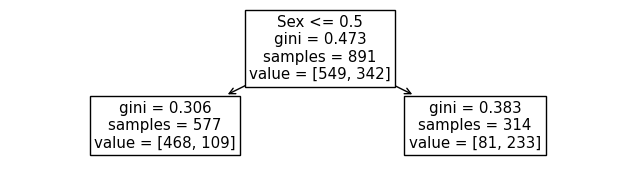

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

plt.figure(figsize=(8, 2))

clf_dt = DecisionTreeClassifier(max_depth=1)
clf_dt.fit(df_titanic[X_all], df_titanic['Survived'])
plot_tree(clf_dt, feature_names=X_all)
plt.show()

In [18]:
0.473 - 0.306 * 577 / 891 - 0.383 * 314 / 891

0.13986419753086418

### 나무의 성장 방법

- 레벨기준(Level(Depth)-Wise)

나무의 레벨을 기준으로 나무를 성장 시킵니다.

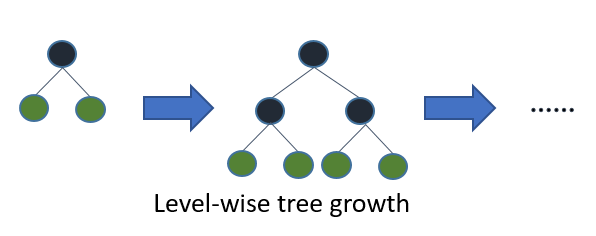

※ 이미지 출처: https://lightgbm.readthedocs.io/en/latest/Features.html

- 성능기준(Leaf-Wise, Best-First)

나무의 불순도 차감을 기준으로 나무를 성장 시킵니다.

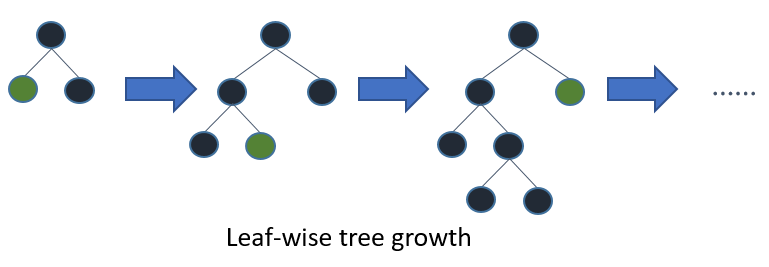
※ 이미지 출처: https://lightgbm.readthedocs.io/en/latest/Features.html

sklearn.tree.DecisionTree(Classifier, Regressor) 에서는 max_leaf_nodes 설정을 하면 Best-First 방식으로 동작합니다.

sklearn.tree.DecisionTree(Classifier, Regressor) 매뉴얼 발췌
```
max_leaf_nodes: int, default=None
    Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
```

**[Ex.3]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_titanic에서 입력 변수를 X_all 대상 변수를 Survived로 했을 때,

레벨 기준 성장 방법과 성능 기준 성장 방법의 차이점을 확인해봅니다.

</div>

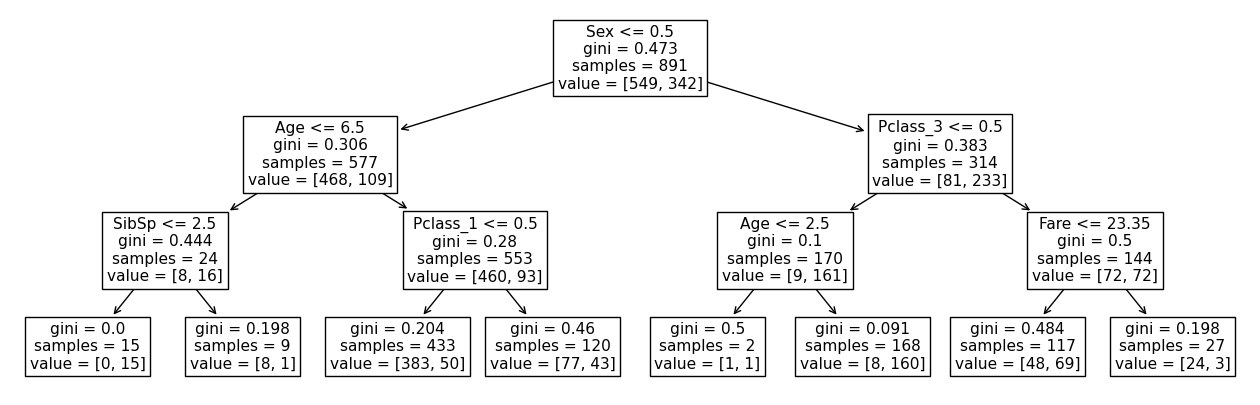

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(16, 5))

clf_dt = DecisionTreeClassifier(max_depth=3, random_state=123)
clf_dt.fit(df_titanic[X_all], df_titanic['Survived'])
plot_tree(clf_dt, feature_names=X_all)
plt.show()

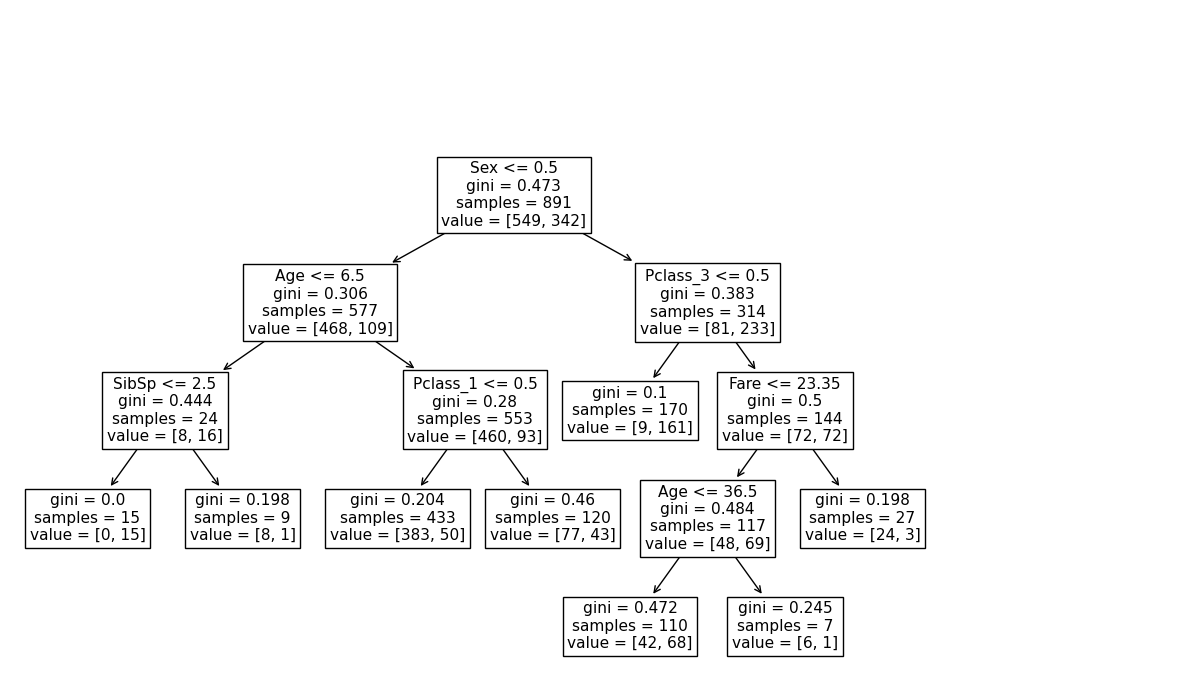

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(12, 7))
clf_dt = DecisionTreeClassifier(max_leaf_nodes=8)
clf_dt.fit(df_titanic[X_all], df_titanic['Survived'])
plot_tree(clf_dt, feature_names=X_all)

plt.tight_layout()
plt.show()

**장단점 비교**

|방법|장점|단점|
|----|:----|:----|
|Level-wise|구조가 단순하여 해석이 쉽습니다.<br/>계산 비용이 Leaf-wise에 비해 낮습니다.<br/>각 레벨에서 독립적으로 분기를 하므로 병렬화에 용이합니다.|Leaf-wise에 비해 비효율적인 분할을 지닐 가능성이 높습니다.|
|Leaf-wise|효과가 높은 것을 우선 분기하여 최적의 구조를 찾을 가능성이 높습니다.|계산 비용이 Level-wise에 비해 높습니다.<br/> 과적합 가능성이 Level-wise에 비해 높습니다.<br/>최선의 노드를 선택 후에 분기를 위한 연산이 일어나는 의존적 구조라 병렬화가 어렵습니다.|


## 4. 가지치기(Pruning)

의사 결정 나무는 데이터에 맞추어 가설 공간을 키워 갈수 있는 구조입니다. 

크기의 제한이 없다면 높은 모델의 복잡도로 인해 지나치게 높은 분산으로 인한 과적합이 발생합니다. 

의사 결정 나무 학습이전에 크기의 제한을 두는 사전가지치기(Pre-pruning)과 

학습후에 크기를 줄이는 사후 가지치기(Post-pruning)가 있습니다.

**sklearn.tree.DecisionTreeClassifier와 DecisionTreeRegressor**

**주요 하이퍼 파라메터**

|하이퍼 파라메터|기능|
|------:|:------|
|max depth|나무가 성장할 수 있는 최대 깊이|
|max_leaf_nodes|최대 리프 노드 수, Leaf-wise 방식으로 성장하게 됩니다.|
|min_samples_split|분기를 위한 최소 샘플 수|
|min_samples_leaf|리프 노드의 최소 샘플 수|
|min_impurity_decrease|분기에 필요한 최소 불순도 차감|
|min_impurity_split|분기에 필요한 최소 불순도|

예제에 활용하기 위해 df_titanic에서 80%는 학습 데이터 df_train으로 20%는 평가데이터 df_test로 Survived 비율이 동일하게 나눕니다.

In [21]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_titanic, train_size=0.8, stratify=df_titanic['Survived'], random_state=123)

**[Ex.4]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

max_depth 에 따라 학습과 평가의 성능이 어떻게 변하는지 확인합니다.

입력 변수는 X_all 리스트에 있는 변수이고, 대상 변수는 Survived 입니다.

성능 측정 지표는 정확도(Accuracy) 입니다.

```
max_depths = np.arange(2, 13)
```
    
</div>

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_depths = np.arange(2, 13)
acc_train, acc_test = list(), list()
for max_depth in max_depths:
    clf_dt = DecisionTreeClassifier(max_depth=max_depth, random_state=123)
    clf_dt.fit(df_train[X_all], df_train['Survived'])
    acc_test.append(
        accuracy_score(df_test['Survived'], clf_dt.predict(df_test[X_all]))
    )
    acc_train.append(
        accuracy_score(df_train['Survived'], clf_dt.predict(df_train[X_all]))
    )

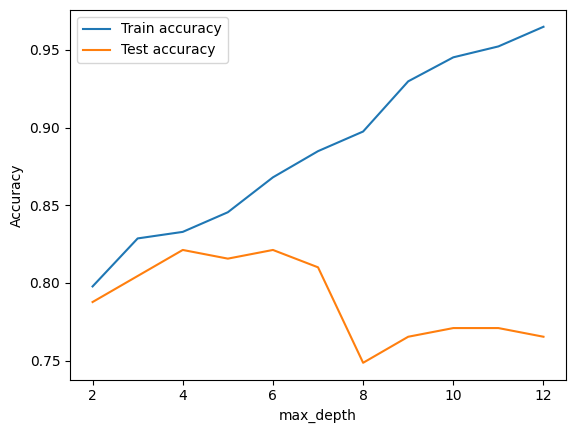

In [23]:
plt.plot(max_depths, acc_train, label='Train accuracy')
plt.plot(max_depths, acc_test, label='Test accuracy')
plt.gca().set_xlabel('max_depth')
plt.gca().set_ylabel('Accuracy')
plt.legend()
plt.show()

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

max_leaf_nodes 에 따라 학습과 평가의 성능이 어떻게 변하는지 확인합니다.


```
max_leaf_nodes_list = np.arange(2, 10) ** 2
```
</div>

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

max_leaf_nodes_list = np.arange(2, 10) ** 2
acc_train, acc_test = list(), list()
for max_leaf_nodes in max_leaf_nodes_list:
    clf_dt = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, random_state=123)
    clf_dt.fit(df_train[X_all], df_train['Survived'])
    acc_test.append(
        accuracy_score(df_test['Survived'], clf_dt.predict(df_test[X_all]))
    )
    acc_train.append(
        accuracy_score(df_train['Survived'], clf_dt.predict(df_train[X_all]))
    )

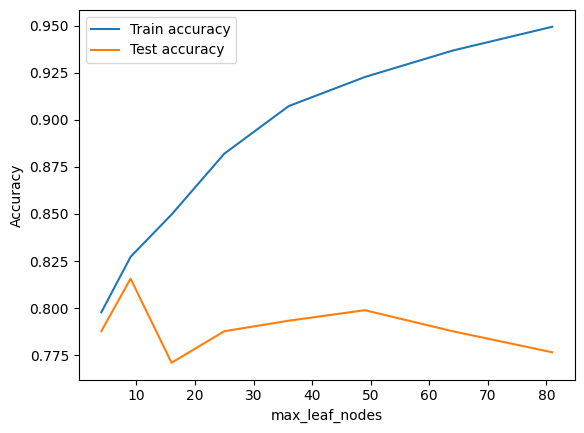

In [25]:
plt.plot(max_leaf_nodes_list, acc_train, label='Train accuracy')
plt.plot(max_leaf_nodes_list, acc_test, label='Test accuracy')
plt.gca().set_xlabel('max_leaf_nodes')
plt.gca().set_ylabel('Accuracy')
plt.legend()
plt.show()

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

min_samples_leaf 에 따라 학습과 평가의 성능이 어떻게 변하는지 확인합니다.


```
min_samples_leafs = np.arange(2, 33, 2)
```
</div>

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

min_samples_leafs  = np.arange(2, 64, 4)
acc_train, acc_test = list(), list()
for min_samples_leaf in min_samples_leafs :
    clf_dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=123)
    clf_dt.fit(df_train[X_all], df_train['Survived'])
    acc_test.append(
        accuracy_score(df_test['Survived'], clf_dt.predict(df_test[X_all]))
    )
    acc_train.append(
        accuracy_score(df_train['Survived'], clf_dt.predict(df_train[X_all]))
    )

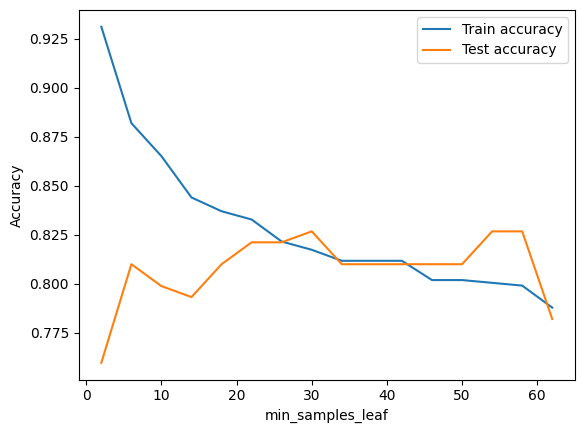

In [27]:
plt.plot(min_samples_leafs, acc_train, label='Train accuracy')
plt.plot(min_samples_leafs, acc_test, label='Test accuracy')
plt.gca().set_xlabel('min_samples_leaf')
plt.gca().set_ylabel('Accuracy')
plt.legend()
plt.show()

## 의사 결정 나무의 장단점

### 장점

- 데이터의 전처리의 필요성이 적습니다.


- 이상치에 상대적으로 덜 민감합니다.


- 직관적인 해석을 할 수 있는 형태를 보입니다.


- 모델에 가정을 두고 있지 않으므로, 다양한 문제에 적용할 수 있습니다.

### 단점

- 과적합에 대응하기 위한 모델의 최적화가 상대적으로 많이 필요합니다.


- 데이터의 작은 변화에도 모델의 출력 결과가 크게 변하기 쉽습니다. 